# Simple Tickets prediction with DNN

Goal: Predict the number of tickets requested by different clients

Here we demonstrate how a neural network can be used in very simple projects originally designed for linear models

Data taken from [Udacity's problem solving with advanced analytics](https://www.udacity.com/course/problem-solving-with-advanced-analytics--ud976)

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Load and prepare the data

In [2]:
train_data_path = 'data/simple_tickets_data.csv'
df = pd.read_csv(train_data_path)
original_df=df
print(df.shape)
df.head()

(300, 5)


,Client ID,Average Number of Tickets,Number of Employees,Value of Contract,Industry
0,TK669,90,561,200000,Retail
1,EY859,85,530,200000,Retail
2,TN571,5,82,25000,Manufacturing
3,LJ675,82,491,225000,Manufacturing
4,KH713,12,230,75000,Services


In [3]:
targets = ['Average Number of Tickets']
features = ['Number of Employees', 'Value of Contract', 'Industry']

df = df[features + targets]

# convert dataframe values to numerical
# df = df.apply(pd.to_numeric, errors='coerce')

categorical = [feat for feat in features if df[feat].dtype == 'object']
numerical = [feat for feat in features if df[feat].dtype != 'object']

print("Categorical features: \t{}".format(categorical))
print("Numerical features: \t{}".format(numerical))


# Reeplace NaN values by mean (numerical) or 'No Data' (categorical) 
df = df.fillna(df[numerical].mean())
df = df.replace(np.nan, 'No Data', regex=True)

#df[numerical].dtypes

Categorical features: 	['Industry']
Numerical features: 	['Number of Employees', 'Value of Contract']


### Visualize data

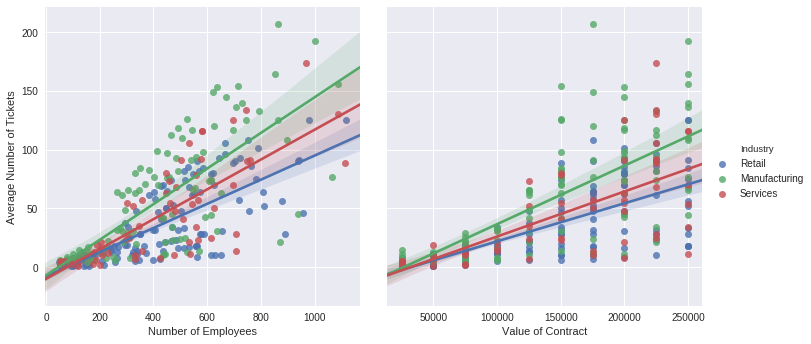

In [4]:
g = sns.PairGrid(df, y_vars=targets, x_vars=numerical, size=5, hue='Industry')
g.map(sns.regplot).add_legend()

#sns.pairplot(df, hue = 'Industry', vars=['Number of Employees', 'Value of Contract'] + targets, size = 4)

The plotting shows that a linear model could be enough to make predictions

### Dummy variables

In [5]:
dummy_fields = categorical

# Process categorical variables 
dummy_fields = [d for d in dummy_fields if d in df]
for each in dummy_fields:
    dummies = pd.get_dummies(df[each], prefix=each, drop_first=False)
    df = pd.concat([df, dummies], axis=1)

df = df.drop(dummy_fields, axis='columns')

features_list = list(df.drop(targets, axis=1))
print(features_list)
df.head()

['Number of Employees', 'Value of Contract', 'Industry_Manufacturing', 'Industry_Retail', 'Industry_Services']


,Number of Employees,Value of Contract,Average Number of Tickets,Industry_Manufacturing,Industry_Retail,Industry_Services
0,561,200000,90,0,1,0
1,530,200000,85,0,1,0
2,82,25000,5,1,0,0
3,491,225000,82,1,0,0
4,230,75000,12,0,0,1


### Scaling variables
The scaling factors are saved so we can go backwards when we use the network for predictions.

In [6]:
quant_features = numerical

# Store scalings in a dictionary so we can convert back later
scaled_features = {}
for f in quant_features:
    mean, std = df[f].mean(), df[f].std()
    scaled_features[f] = [mean, std]
    df.loc[:, f] = (df[f] - mean)/std

scaled_targets = {}
for f in targets:
    mean, std = df[f].mean(), df[f].std()
    scaled_targets[f] = [mean, std]
    df.loc[:, f] = (df[f] - mean)/std    
    
df.head()

,Number of Employees,Value of Contract,Average Number of Tickets,Industry_Manufacturing,Industry_Retail,Industry_Services
0,0.569857,0.802960,1.066255,0,1,0
1,0.443566,0.802960,0.948835,0,1,0
2,-1.381540,-1.623250,-0.929891,1,0,0
3,0.284684,1.149562,0.878383,1,0,0
4,-0.778603,-0.930047,-0.765502,0,0,1


### Tune features selection
Fast way to remove features before training the model

In [7]:
fields_to_drop = []
data = df.drop(fields_to_drop, axis=1)

# filtered dataset now in 'data'

### Splitting the data into training, testing, and validation sets

In [8]:
from sklearn.model_selection import train_test_split

#train, test = train_test_split(data,  test_size=0, random_state=0)
train = data

# Separate the data into features and targets (x=features, y=targets)
x_train, y_train = train.drop(targets, axis=1).values, train[targets].values
# x_test, y_test = test.drop(targets, axis=1).values, test[targets].values
# _nc: non-categorical yet

## Deep Neural Network
  

Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 2)                 12        
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 3         
Total params: 15.0
Trainable params: 15
Non-trainable params: 0.0
_________________________________________________________________
Training ....
Epoch 00562: early stopping
Training: loss: 0.398


(0, 1)

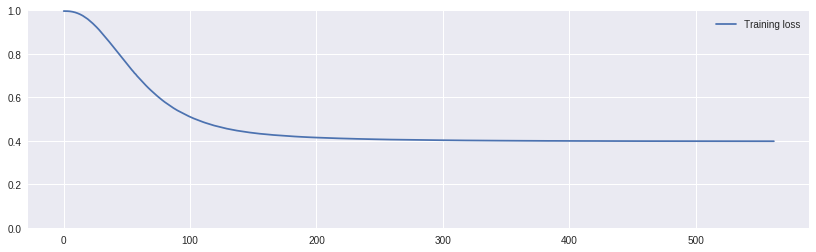

In [9]:
np.random.seed(0)
import keras
from keras.models import Sequential
from keras.layers.core import Dense, Dropout
keras.optimizers.Adam

nodes = x_train.shape[1]

weights = keras.initializers.RandomNormal(stddev=0.001)

model = Sequential()
model.add(Dense(nodes//2, input_dim=x_train.shape[1], activation='relu',
               kernel_initializer=weights,
               bias_initializer = weights))
model.add(Dense(1, activation=None,
               kernel_initializer = weights,
               bias_initializer = weights))


#opt = keras.optimizers.Adam(lr=0.00001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
opt = keras.optimizers.adam()

model.compile(loss='mean_squared_error', optimizer=opt)
model.summary()

callbacks = [keras.callbacks.EarlyStopping(monitor='loss', patience=10, verbose=1)]

print('Training ....')

history = model.fit(x_train, y_train, epochs=10000, batch_size=64, verbose=0, 
                    validation_split=0, callbacks=callbacks)

print("Training: loss: {:.3f}".format(history.history['loss'][-1]))
# print("Accuracy: loss: {:.3f} ... Validation Accuracy: {:.3f}".format(
#     history.history['acc'][-1], history.history['val_acc'][-1]))

plt.figure(figsize=(14, 4))

plt.plot(history.history['loss'], label='Training loss')
#plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()
plt.ylim(ymin=0, ymax=1)

## Predicting the test features

In [10]:
# score = model.evaluate(x_test, y_test, verbose=1)
# print("\n Test loss: {:.4f}".format(score))

pred = model.predict(x_train, verbose=1)
restore_pred = pred * scaled_targets['Average Number of Tickets'][1] + scaled_targets['Average Number of Tickets'][0]

restore_pred = restore_pred.round()
tickets = pd.DataFrame({'Predicted Tickets': np.squeeze(restore_pred)})
extended_df = pd.concat([original_df, tickets], axis=1)
extended_df.head(10)

 32/300 [==>...........................] - ETA: 0s

,Client ID,Average Number of Tickets,Number of Employees,Value of Contract,Industry,Predicted Tickets
0,TK669,90,561,200000,Retail,53.0
1,EY859,85,530,200000,Retail,50.0
2,TN571,5,82,25000,Manufacturing,7.0
3,LJ675,82,491,225000,Manufacturing,78.0
4,KH713,12,230,75000,Services,9.0
5,NU563,74,613,225000,Manufacturing,90.0
6,JB001,7,332,125000,Services,27.0
7,RK635,58,405,175000,Retail,33.0
8,OL292,8,224,100000,Manufacturing,30.0
9,BL855,101,790,200000,Retail,76.0


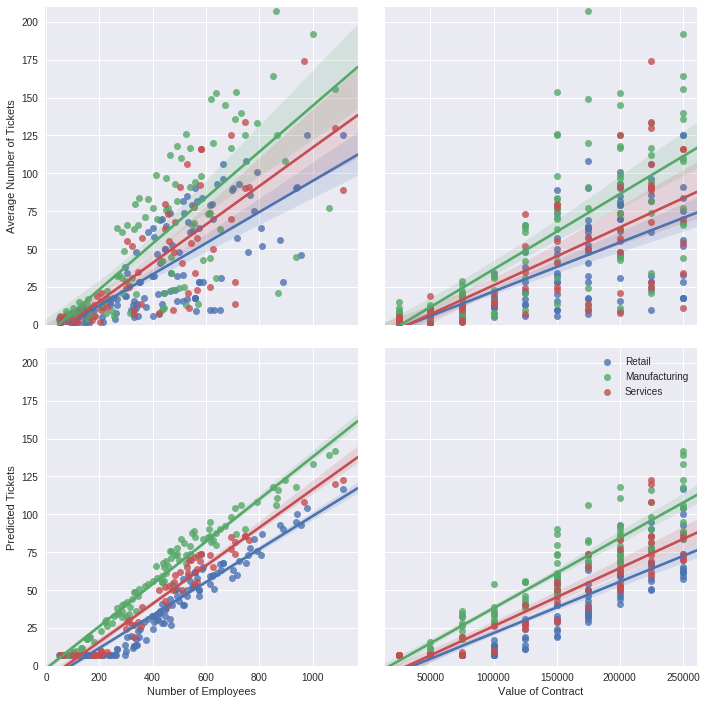

In [11]:
y = ['Average Number of Tickets', 'Predicted Tickets']

g = sns.PairGrid(extended_df, y_vars=y, x_vars=numerical, size=5, hue = 'Industry')
g.map(sns.regplot)
g.set(ylim=(0, 210))
plt.legend()

In [12]:
# Single Prediction:

# print(features_list)
# input data: [Employees, Value of contract, Industry_Manufacturing, Industry_Retail, Industry_Services]
single_data = [750, 13000, 1, 0, 0]

# normalize single data
for idx, f in enumerate(quant_features):
    single_data[idx] = (single_data[idx]  - scaled_features[f][0])/scaled_features[f][1]

single_pred = model.predict(np.array([single_data]))    
single_pred = single_pred * scaled_targets['Average Number of Tickets'][1] + scaled_targets['Average Number of Tickets'][0]
single_pred = single_pred.round()
print('Predicted Number of Tickets: {}'.format(single_pred))

Predicted Number of Tickets: [[ 67.]]
